# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier#из нашего файлика
from metrics import binary_classification_metrics, multiclass_accuracy

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не хватать ОЗУ, то берите меньше).

In [4]:
X, y = fetch_openml(name = 'Fashion-MNIST', return_X_y = True, as_frame = False)

/home/fvelikon/miniconda3/envs/fraud_detect/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [5]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace = False, size = 1000)
X = X[idx_to_stay]
y = y[idx_to_stay].astype(int)

Давайте посмотрим на какое-нибудь изображение из наших данных:

(-0.5, 27.5, 27.5, -0.5)

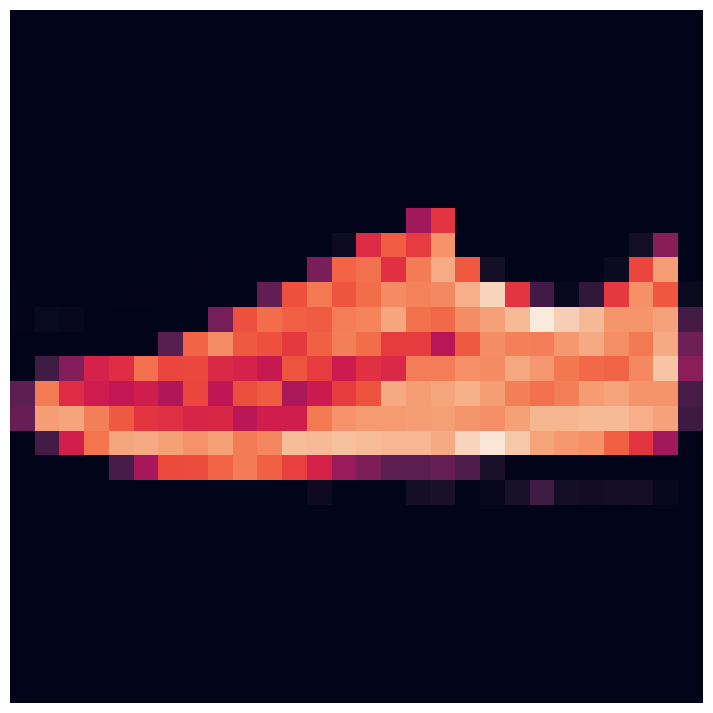

In [6]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28)
plt.imshow(image)
plt.axis('off')

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

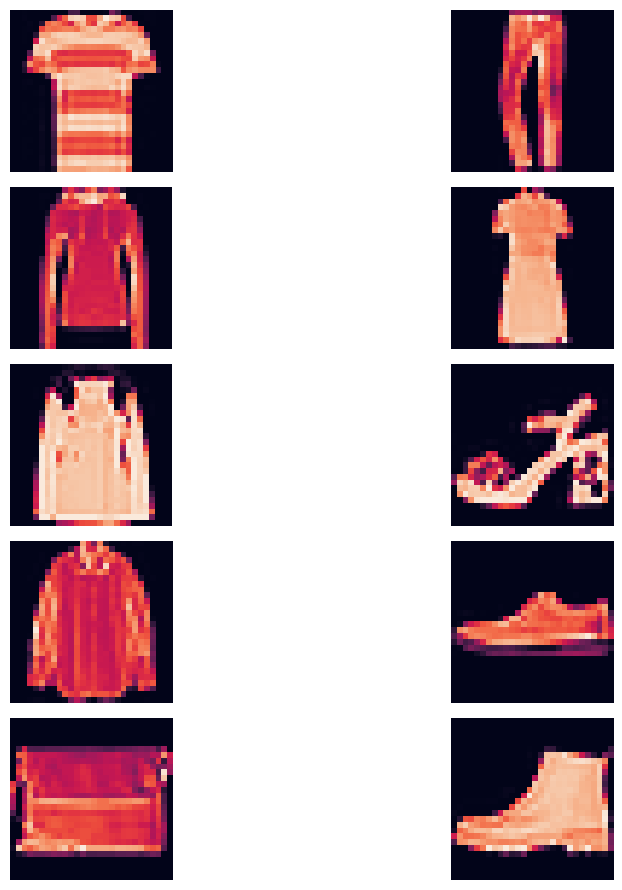

In [7]:
fig, axes = plt.subplots(5, 2)
for i in range(10):
    row_idx = i // 2
    col_idx = i % 2
    indexes = np.where(y == i)
    image = X[np.random.choice(indexes[0])].reshape(28, 28)
    axes[row_idx, col_idx].imshow(image)
    axes[row_idx, col_idx].axis('off')
fig.tight_layout()
plt.show()

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

There are only: [0 1 2 3 4 5 6 7 8 9]


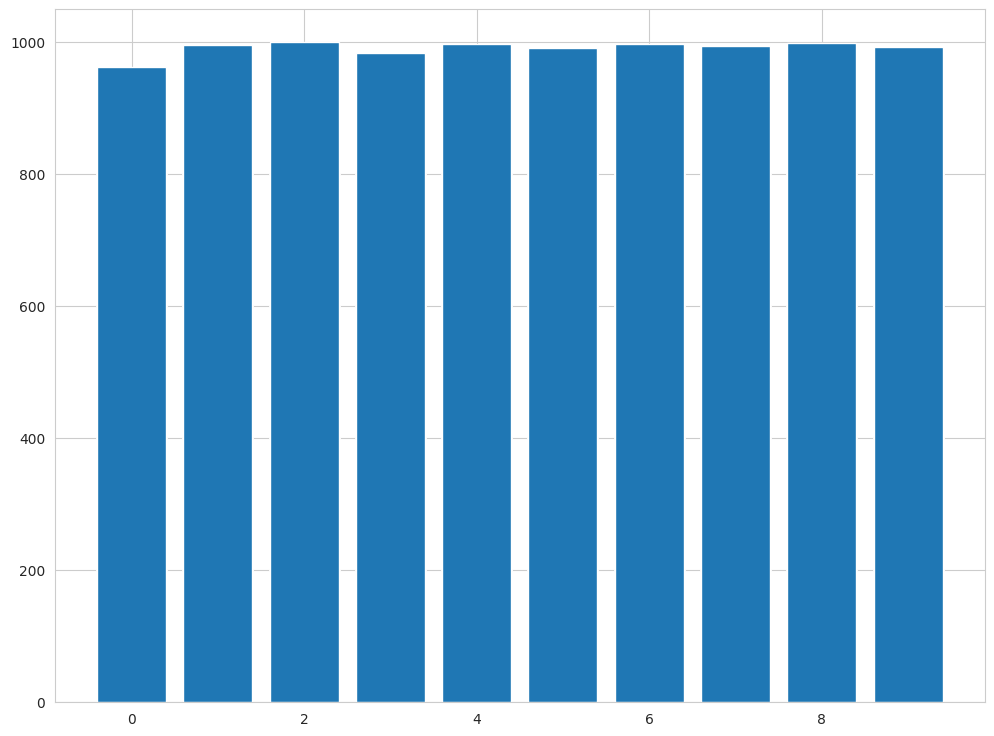

In [8]:
#чекнем, что точно только 10 классов:
print('There are only:', np.unique(y))
#теперь баланс классов
plt.bar(y,np.arange(len(y)))
plt.show()

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [9]:
binary_train_X, binary_test_X, binary_train_y, binary_test_y = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state=SEED)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [10]:
train_ids = np.where((binary_train_y == 0) | (binary_train_y == 1))
test_ids = np.where((binary_test_y == 0) | (binary_test_y == 1))
binary_train_X = binary_train_X[train_ids]
binary_test_X = binary_test_X[test_ids]
binary_train_y = binary_train_y[train_ids]
binary_test_y = binary_test_y[test_ids]
print('Train:', binary_train_y.shape[0], ' Test:', binary_test_y.shape[0])

Train: 159  Test: 36


И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [11]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [12]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [13]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [14]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [15]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

62.7 ms ± 323 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.45 ms ± 14 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.2 ms ± 52.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Реализуем метод для предсказания меток класса

In [16]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [17]:
# TODO: binary_classification_metrics in metrics.py

In [18]:
metrics = binary_classification_metrics(binary_test_y, prediction) #Accuracy Precision Recall F1-score

print(f'Accuracy = {metrics[0]}\nPrecision = {metrics[1]}\nRecall = {metrics[2]}\nF1-score = {metrics[3]}')   

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1-score = 1.0


Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(f'Accuracy = {accuracy_score(binary_test_y, prediction)}\nPrecision = {precision_score(binary_test_y, prediction)}\nRecall = {recall_score(binary_test_y, prediction)}\nF1-score = {f1_score(binary_test_y, prediction)}')   

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1-score = 1.0


### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [20]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = []
    test_metrics = []
    
    for k in params:
        knn_classifier = KNNClassifier(k = k)
        knn_classifier.fit(X_train, y_train)
        prediction_train = knn_classifier.predict(X_train)
        train_metrics.append(metric(y_true = y_train, y_pred = prediction_train))
        prediction_test = knn_classifier.predict(X_test)
        test_metrics.append(metric(y_true = y_test, y_pred = prediction_test))
    return train_metrics, test_metrics

In [22]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, recall_score)
#В данной задаче, допустим, для нас нет преференций в том, чтобы ошибаться, говоря 0 или говоря 1. 
#Но реализация алгоритма такова, что, если k чётное и среди "ближайших соседей" одинаково и 0, и 1, то модель выдаст наименьшее по значению, т.е. 0 (из-за np.bincount) 
#Таким образом, кажется, что модель чаще будет выдавать 0, т.е. можно ожидать, что будет больше FN предсказаний.
#Посмотрим recall, чтобы минимизировать этот эффект. 

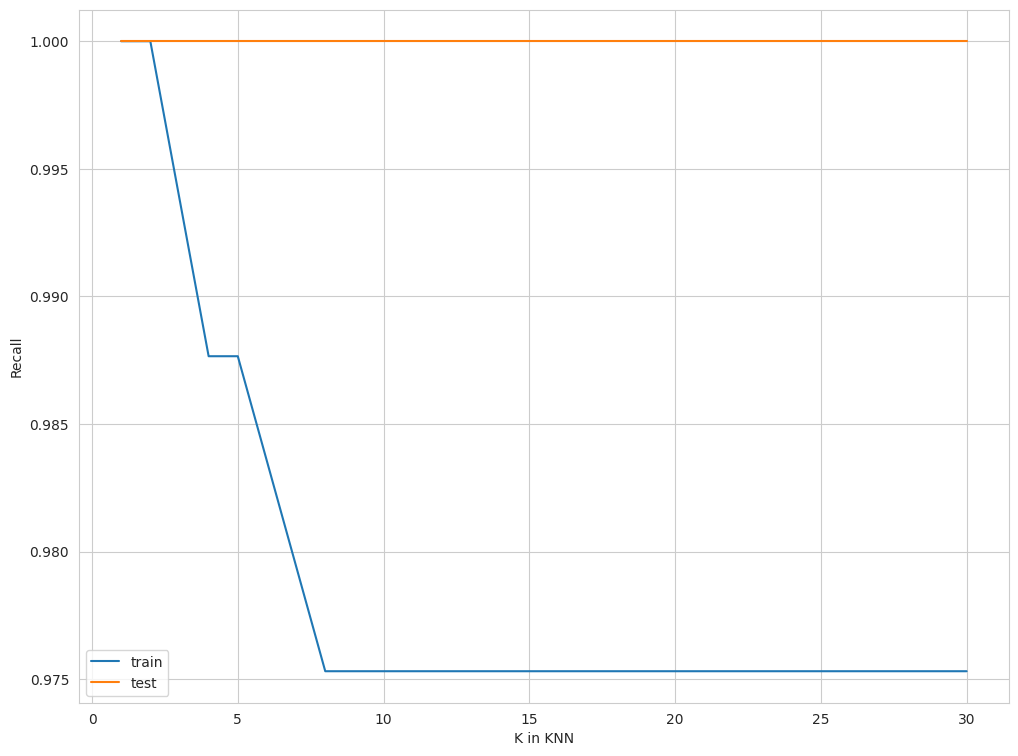

In [23]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Recall");

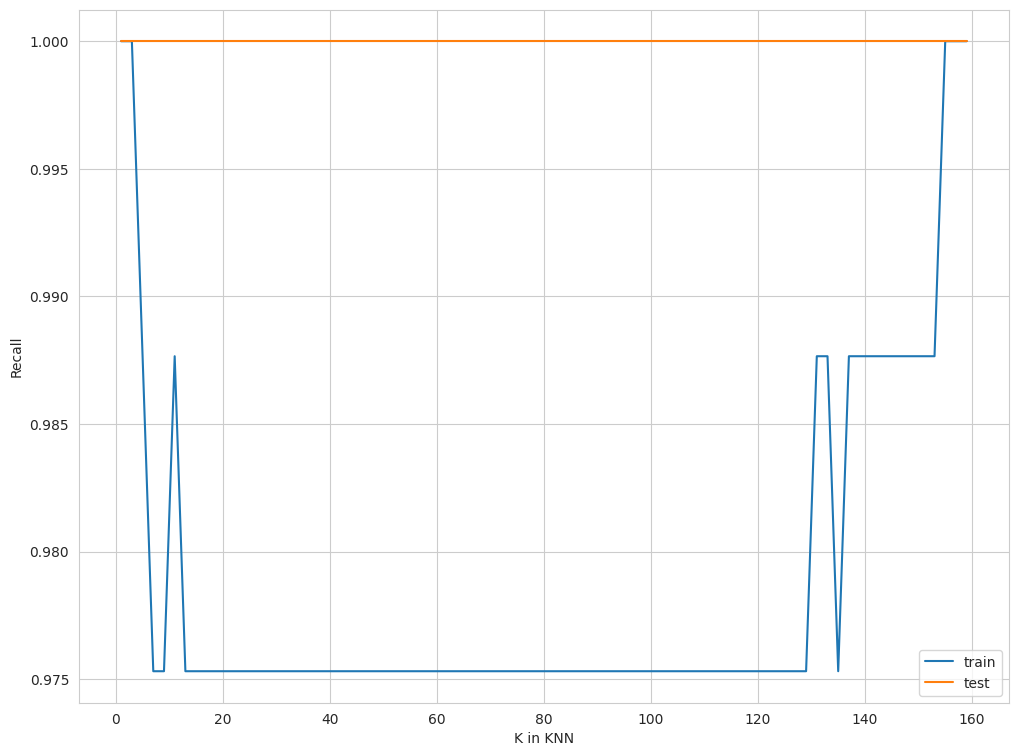

In [24]:
#тестим только на нечётных k и побольше значений (здесь уже не будет такого, что одинаковое количество класса 0 и 1, и FN не завышается)
params = np.arange(1, 160, 2).tolist()#в трейне у нас всего 159 значений, т.е. максимальное число соседей как раз 159.
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, recall_score)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Recall");

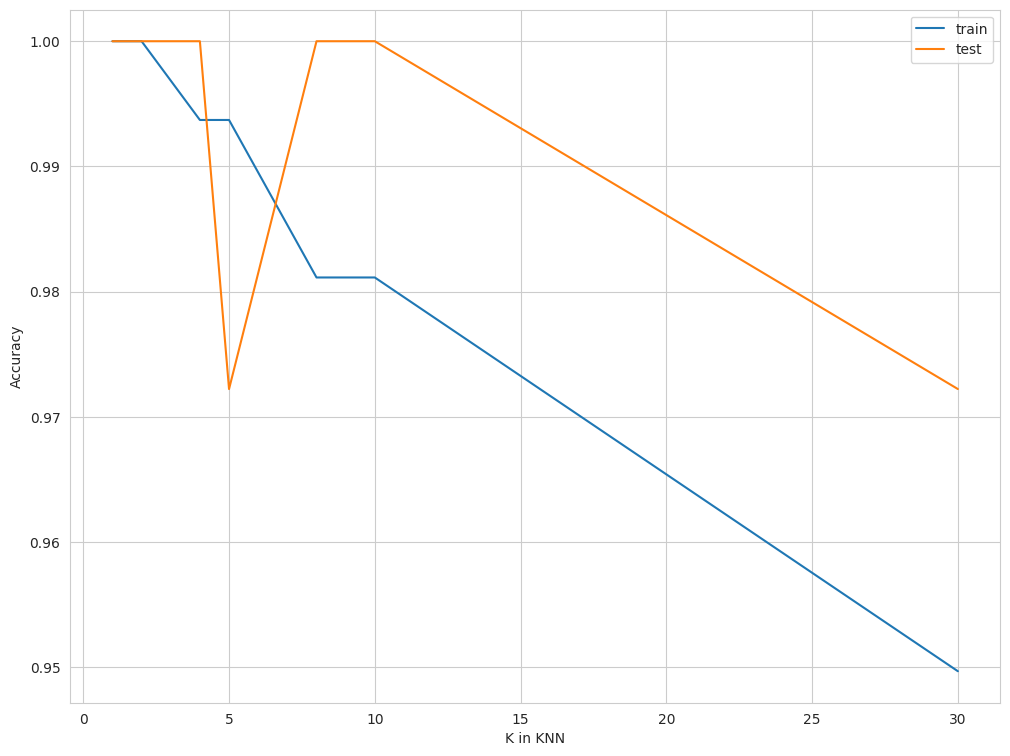

In [25]:
# Глянем на простую Accuracy (всё равно нет преференций в какую сторону хуже предсказывать и на нечётных FN не завышается)
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy");

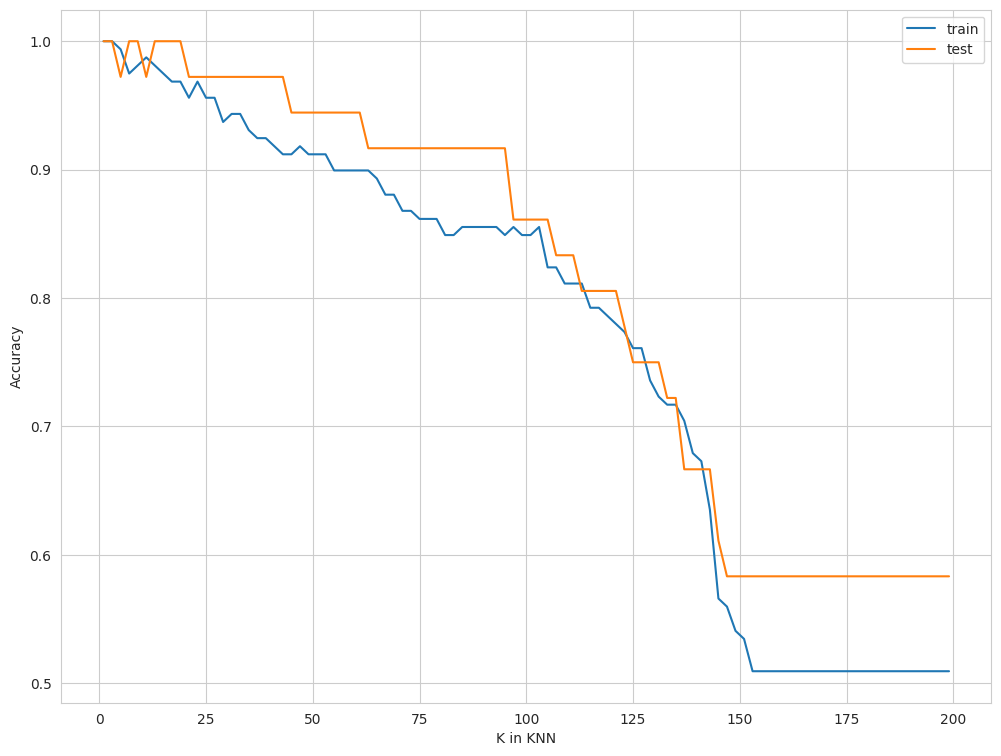

In [26]:
#если взять побольше значений k для accuracy (только нечёт)
params = np.arange(1, 200, 2).tolist()
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy");

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
knn_classifier = KNNClassifier(k = 40)
knn_classifier.fit(binary_train_X, binary_train_y)
prediction = knn_classifier.predict(binary_test_X)
confusion_matrix(binary_test_y, prediction)

array([[14,  1],
       [ 0, 21]])

### 1.5. Многоклассовая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state=SEED)

In [32]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [33]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(y_test, predictions)

0.77

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

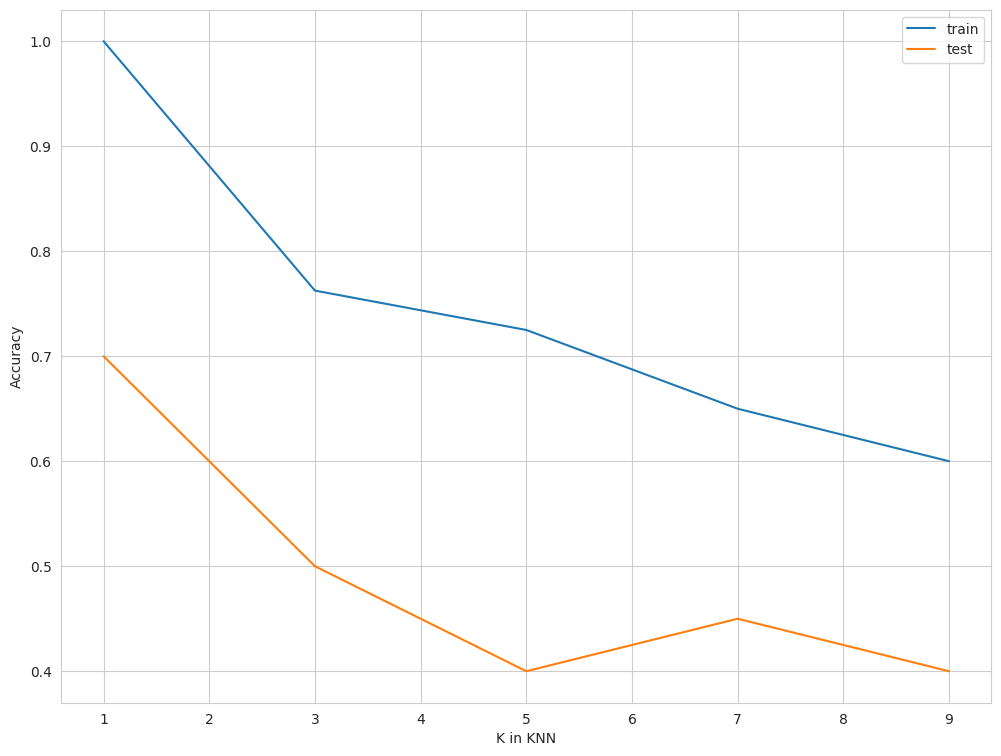

In [35]:
#Побдор k для мультиклассово классификации на подборке поменьше:
#данные
X_less, y_less = fetch_openml(name = 'Fashion-MNIST', return_X_y = True, as_frame = False)
less_idx_to_stay = np.random.choice(np.arange(X_less.shape[0]), replace = False, size = 100)
X_less = X_less[less_idx_to_stay]
y_less = y_less[less_idx_to_stay].astype(int)
#деление тест/трейн
less_train_X, less_test_X, less_train_y, less_test_y = train_test_split(X_less, y_less, 
                                                    test_size = 0.2,
                                                    random_state=SEED)
#подбор k
params = [1, 3, 5, 7, 9]
train_metrics, test_metrics = find_best_k(less_train_X, less_train_y, less_test_X, less_test_y, params, multiclass_accuracy)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy");

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [36]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [37]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [38]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

*В описании к датасету написано "Note: Each of these 10 feature variables __have been mean centered and scaled by the standard deviation times the square root of n_samples__ (i.e. the sum of squares of each column totals 1).". (там как раз видно, что есть возраст отрицательный и пол видимо от 0 и 1 стал 0,05 и -0,04. Поэтому стандартизовать не будем ничего здесь. Но на сами данные посмотрим:*

This dataframe has 442 samples (rows) and 11 columns (variables)

This dataframe contains:
10 numeric variables: age, bmi, bp, s1, s2, s3, s4, s5, s6, target
1 factor variables: sex

---Statistic for factor variables---

-sex-


,value,count,frequency
0,-0.044642,235,0.531674
1,0.050680,207,0.468326



---Statistic for number variables---



,age,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000




There are no NA values in this dataframe.

There are no duplicated rows in this dataframe.

---Correlations---



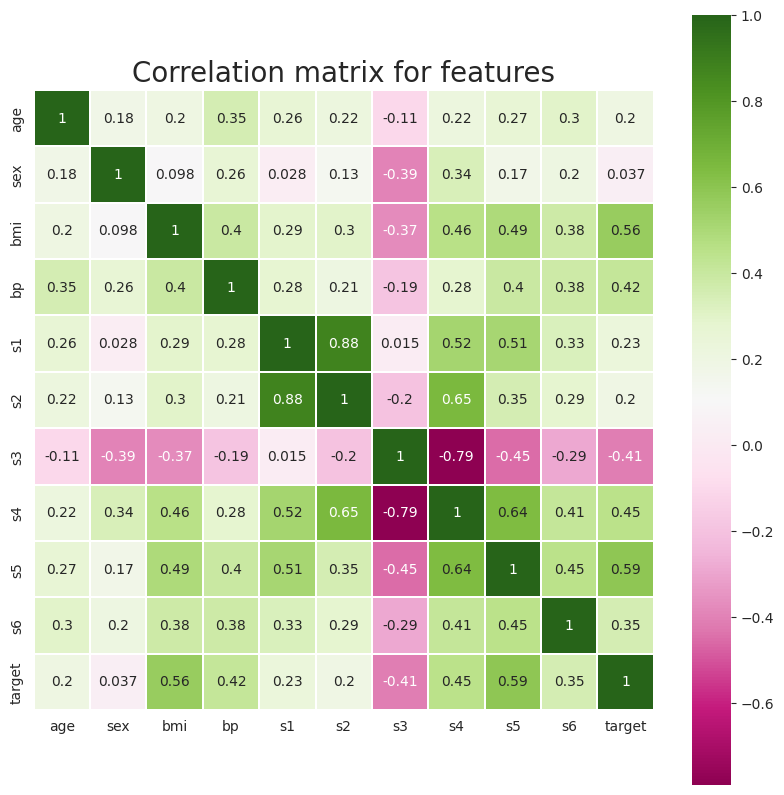


---Box plots---



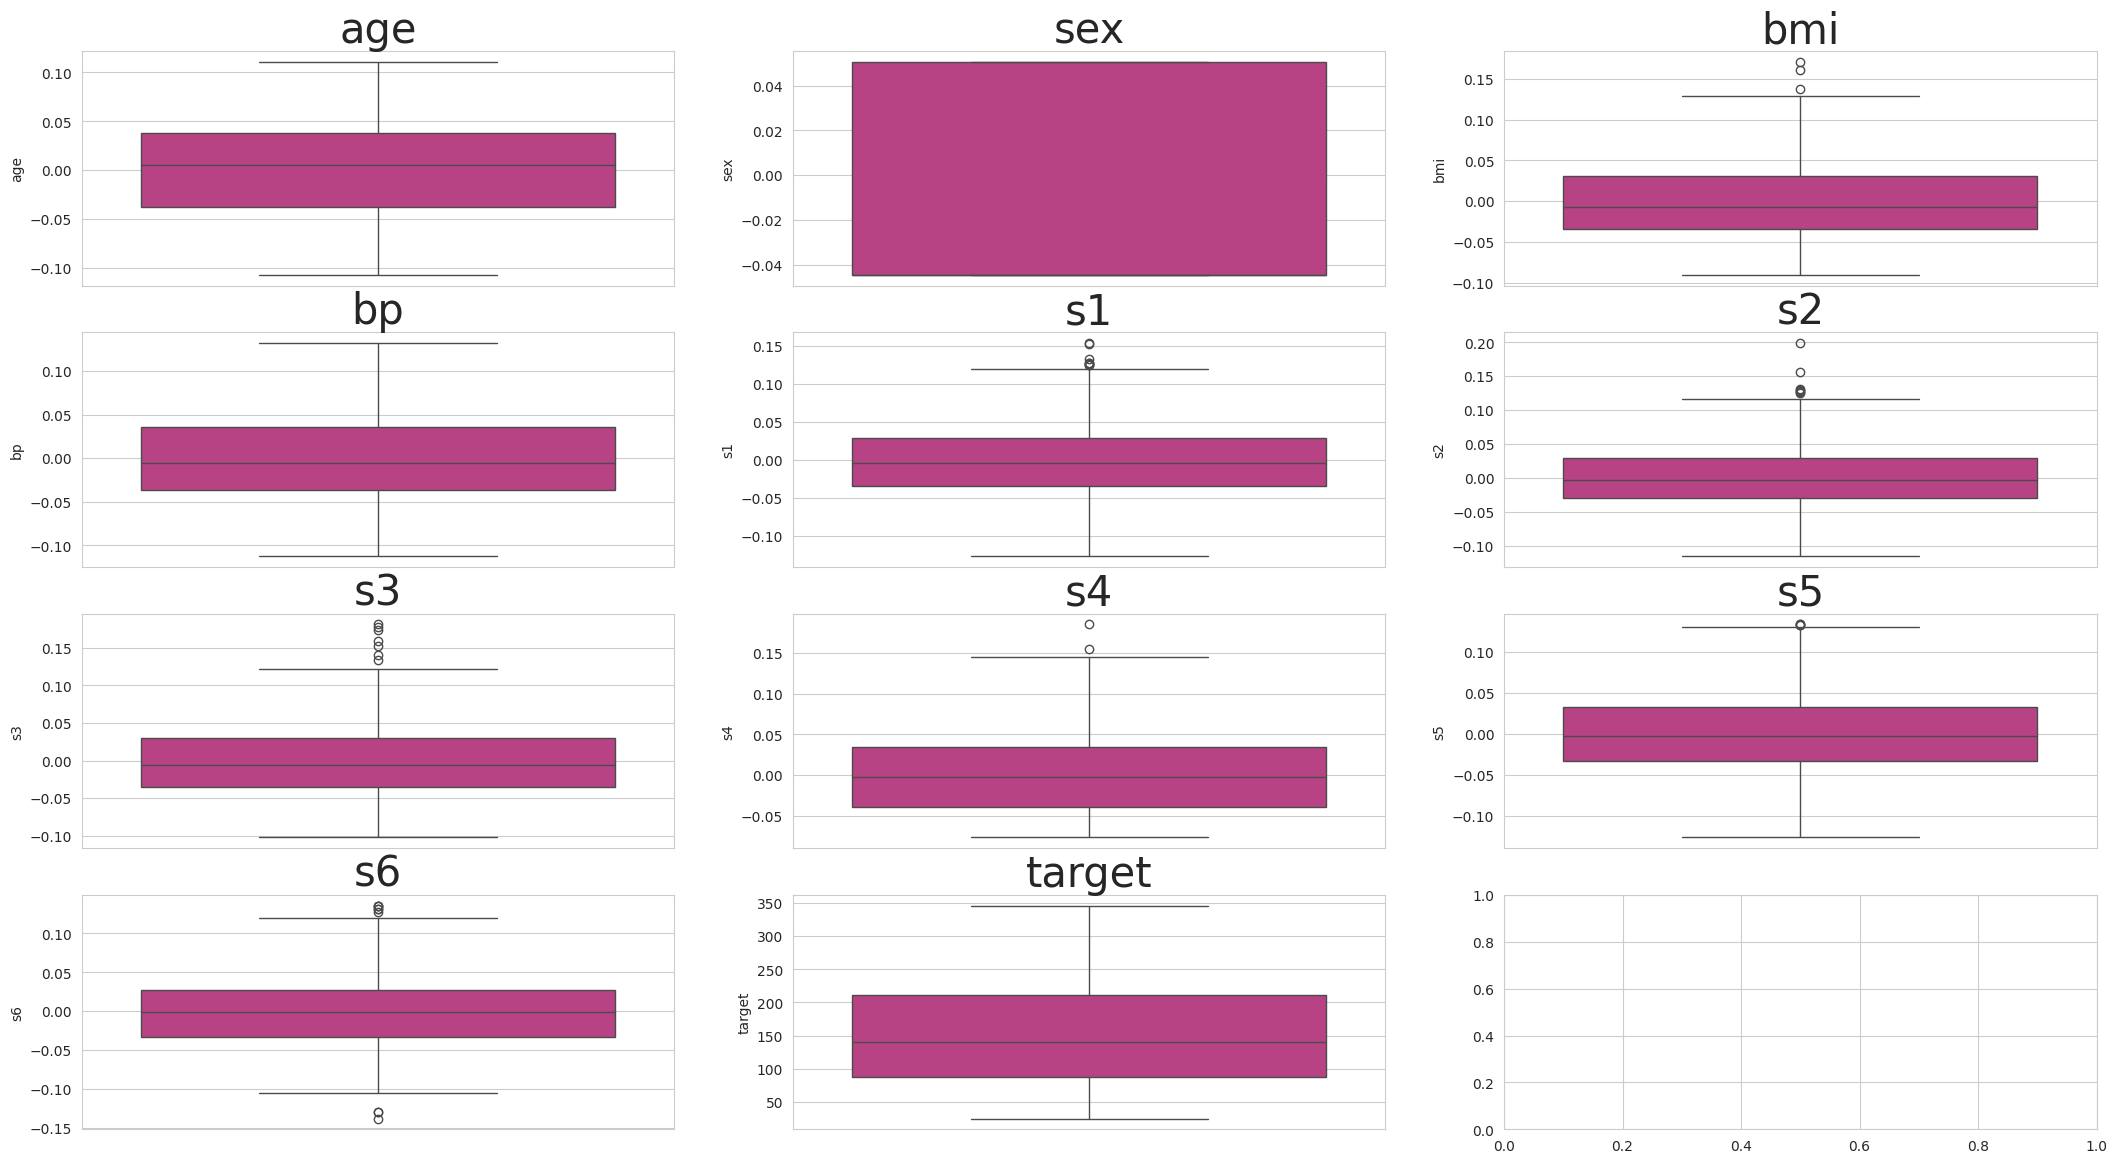

--Histograms--


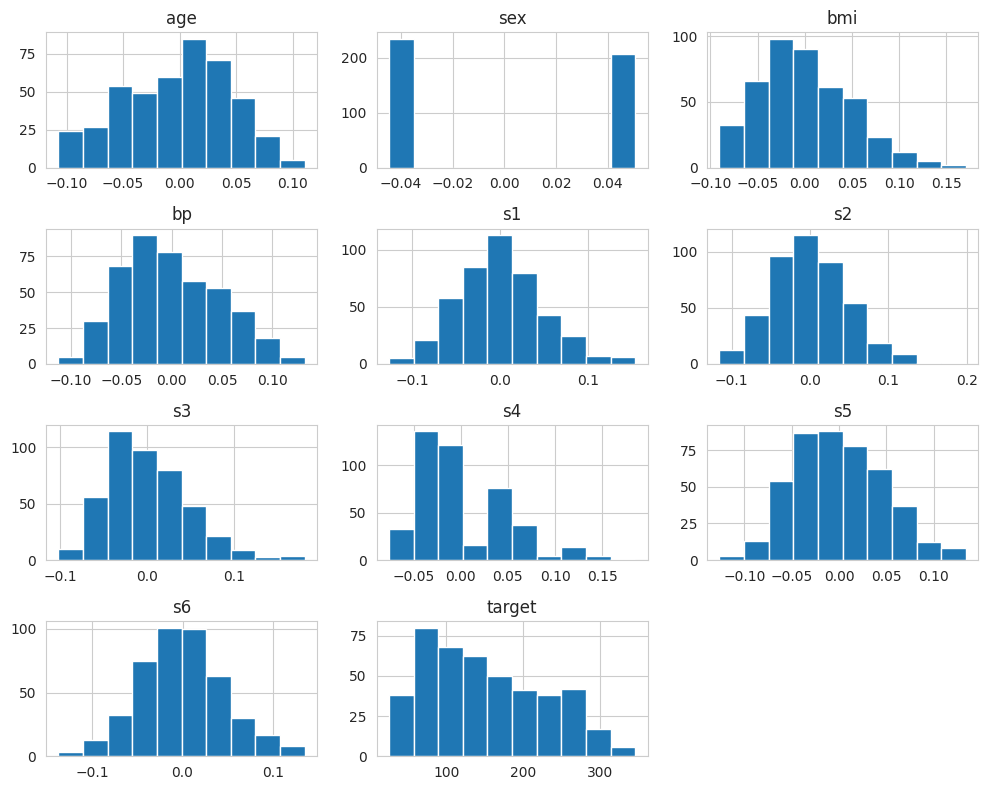

In [41]:
from my_awesome_eda import run_eda
df = pd.concat([X, y], axis=1)
run_eda(df)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state=SEED)

In [43]:
from sklearn.pipeline import Pipeline
#через пайплайн в самом конце всё вместе

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на тренеровочных данных и сделайте предсказания.

In [45]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [46]:
# TODO: r_squared, mse, mae in metrics.py

In [47]:
from metrics import r_squared, mse, mae

In [48]:
print(f'R-square = {r_squared(y_true = y_test, y_pred = y_pred)}\nMSE = {mse(y_true = y_test, y_pred = y_pred)}\nMAE = {mae(y_true = y_test, y_pred = y_pred)}')   

R-square = -0.0011551548418873292
MSE = 4705.876404494382
MAE = 52.61797752808989


In [49]:
#чекнем с склёрном:
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_error)

print(f'R-square = {r2_score(y_true = y_test, y_pred = y_pred)}\nMSE = {mean_squared_error(y_true = y_test, y_pred = y_pred)}\nMAE = {mean_absolute_error(y_true = y_test, y_pred = y_pred)}')   

R-square = -0.0011551548418873292
MSE = 4705.876404494382
MAE = 52.61797752808989


### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [50]:
def find_best_k_regr(X_train, y_train, X_test, y_test, params):
    """
    Choose the best k for KNeighborsRegressor
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    """
    metrics = ['r2', 'mse', 'mae']
    train_metric_values = {metric: [] for metric in metrics}
    test_metric_values = {metric: [] for metric in metrics}
    
    
    for k in params:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        prediction_train = knn.predict(X_train)
        train_metric_values['r2'].append(r_squared(y_true = y_train, y_pred = prediction_train))
        train_metric_values['mse'].append(mse(y_true = y_train, y_pred = prediction_train))
        train_metric_values['mae'].append(mae(y_true = y_train, y_pred = prediction_train))
        
        prediction_test = knn.predict(X_test)
        test_metric_values['r2'].append(r_squared(y_true = y_test, y_pred = prediction_test))
        test_metric_values['mse'].append(mse(y_true = y_test, y_pred = prediction_test))
        test_metric_values['mae'].append(mae(y_true = y_test, y_pred = prediction_test))
        

    plt.plot(params, train_metric_values['r2'], label='train')
    plt.plot(params, test_metric_values['r2'], label='test')
    plt.xlabel('k')
    plt.ylabel('Metric Value')
    plt.title('R2-Score')
    plt.legend()
    plt.show()
    
    
    plt.plot(params, train_metric_values['mse'], label='train')
    plt.plot(params, test_metric_values['mse'], label='test')
    plt.xlabel('k')
    plt.ylabel('Metric Value')
    plt.title('Mean Squared Error')
    plt.legend()
    plt.show()
    
    
    plt.plot(params, train_metric_values['mae'], label='train')
    plt.plot(params, test_metric_values['mae'], label='test')
    plt.xlabel('k')
    plt.ylabel('Metric Value')
    plt.title('Mean Absolute Error')
    plt.legend()
    plt.show()   

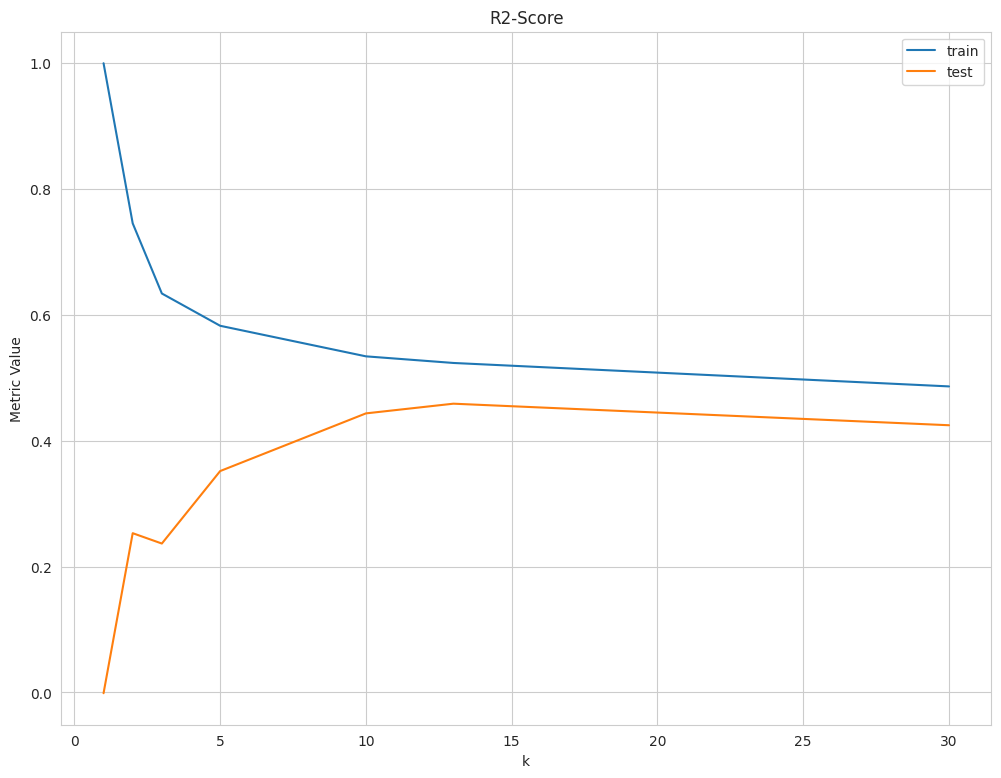

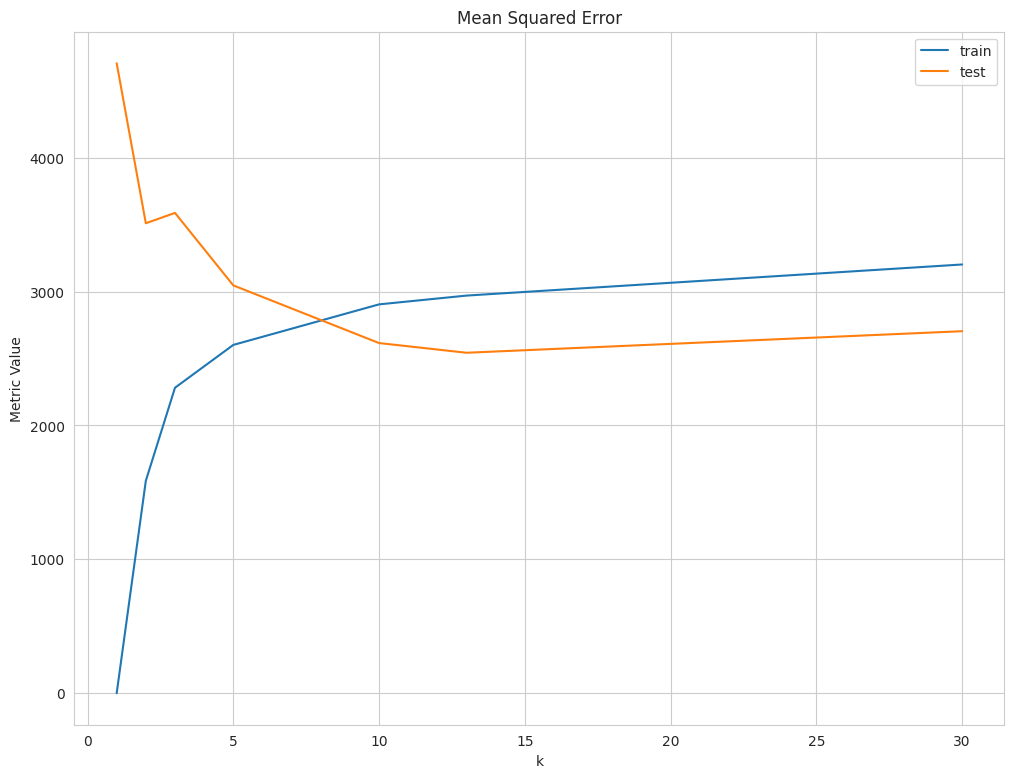

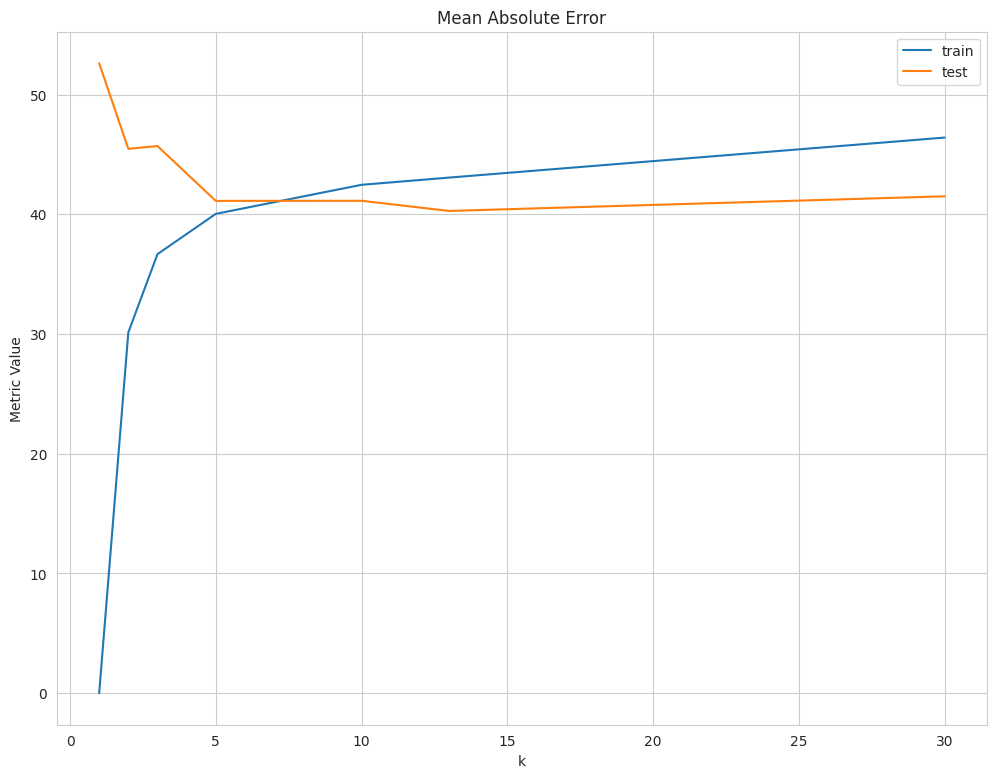

In [51]:
params = [1, 2, 3, 5, 10, 13, 30]
find_best_k_regr(X_train, y_train, X_test, y_test, params)

In [52]:
knn = KNeighborsRegressor(n_neighbors=13)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f'R-square = {r_squared(y_true = y_test, y_pred = y_pred)}\nMSE = {mse(y_true = y_test, y_pred = y_pred)}\nMAE = {mae(y_true = y_test, y_pred = y_pred)}')   

R-square = 0.4589541617101196
MSE = 2543.157103915963
MAE = 40.280034572169406


Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

# Теперь всё через pipeline:

In [53]:
from sklearn.pipeline import Pipeline

In [54]:
knn_pipeline = Pipeline( steps=[
    ('knn', KNeighborsRegressor(n_neighbors=1))
])

knn_pipeline.fit(X_train, y_train)
knn_pipeline.predict(X_test)[:10]

array([293.,  96., 259., 122., 123., 248., 210.,  96.,  81.,  71.])

In [55]:
#со сменой параметров
knn_pipeline.set_params(knn__n_neighbors=10).fit(X_train, y_train)
knn_pipeline.predict(X_test)[:10]

array([183.1, 108.5, 140.4, 146.1, 183.9, 212.4, 121.7, 101. , 111.9,
        80.1])

In [56]:
from sklearn.preprocessing import Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [57]:
preprocessor = ColumnTransformer(transformers=[
    ("binarizer", Binarizer(), ['sex']),
    ("ohe", OneHotEncoder(drop="first"), ['sex'])
],  remainder='passthrough')

In [58]:
knn_pipeline = Pipeline( steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=1))
])

knn_pipeline.fit(X_train, y_train)
knn_pipeline.predict(X_test)[:10]

array([293.,  96., 259., 122., 123., 248., 210.,  96.,  81.,  71.])

In [59]:
mse(y_true = y_test, y_pred = knn_pipeline.predict(X_test))

4705.876404494382

In [60]:
knn_pipeline_binary = Pipeline( steps=[
    ('knn', KNNClassifier(k=1))
])

knn_pipeline_binary.fit(binary_train_X, binary_train_y)
knn_pipeline_binary.predict(binary_test_X)[:10]

array([1., 0., 1., 0., 0., 1., 0., 0., 0., 1.])

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме, познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

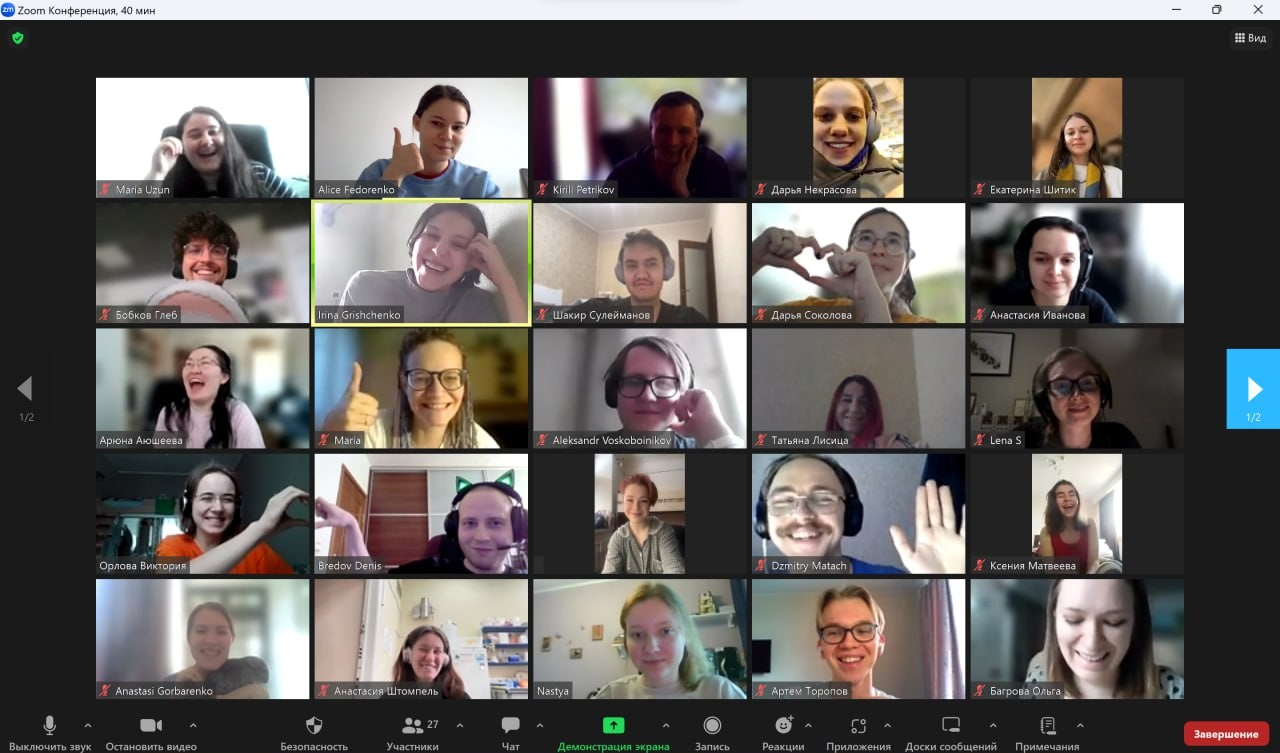

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**


*Очень увлекательно писать от руки реализации (хоть и упрощённые, чем реально используются). Особенно после написания knn для k=1, дойти до подбора k и понять, что надо переписывать под любое k. *
*С Pipeline'ом классно было поиграть. Особенно попытки засунуть в него свои функции (особенно для EDA), но как я поняла, для этого надо было писать так, чтобы был predict и fit (то что в классификации было). То есть любое туда не впихнуть, что логично.*

*Но в целом не понятно насколько это всё-таки правильно всё тут реализовано. И с подбором k тоже как будто туманно осталось. Так что все мысли после фидбэка...*

*Спасибо за домашку*